# Gather data
This also shows the code used to turn the COSMO-GHG output into total vertical columns. Due to file size constraints, we only share the total vertical columns as resulting from the following cell.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# # --- The data was gathered from the COSMO-GHG output as follows
# def convert_to_kg_m3(ds, trace_gas):
#     R_air=287.058
#     rho_moist = ds.P/(R_air*ds.T*(1+0.608*ds.QV))
#     return ds[trace_gas] * rho_moist

# def generate_fluxes(ds, ds0, Z, trace_gas, mode='Cartesian', return_winds=False):
#     '''
#     Compute the flux vector
#     '''
#     # --- Get the density field [level, rlat, rlon]
#     density = convert_to_kg_m3(ds, trace_gas)[0] # there is just one 'time'
    
#     # --- Obtain the depth levels for a numerical integration
#     Z = ((ds0.HHL[0][:-1]+ds0.HHL[0][1:])/2).rename({'level1': 'level'}) # Mid levels
#     dz = -ds0.HHL[0].diff(dim='level1').rename({'level1': 'level'}) # Vertical size of each level

#     # --- Get the total vertical column density: TVCD = \int_0^T \rho(x,y,z) * dz
#     TVCD = (density*dz).sum(dim="level")
    
#     # --- Get the concentration field
#     C0 =  (density)/(TVCD)# Obtain the normalized concentration profile C_0 = \rho / (\int\rho*dz) s.t. integration over z gives \int C_0 dz = 1.
    
#     # --- Fix staggered grid properties of the wind field
#     U = (ds.U[0]).interp(srlon=ds.rlon)
#     V = (ds.V[0]).interp(srlat=ds.rlat)
    
#     # --- Compute the effective wind
#     R = 6375000.0 # Earth radius
#     if mode=='Cartesian':
#         U0 = (U * C0 * dz ).sum(dim="level")
#         V0 = (V * C0 * dz ).sum(dim="level")
#     elif mode=='Spherical':
#         U0 = (U * C0 * (R+Z) * dz ).sum(dim="level")
#         V0 = (V * C0 * (R+Z) * dz * np.cos(np.deg2rad(ds.rlat)) ).sum(dim="level")
#     elif mode=="SphericalAlt":
#         U0 = (U * C0 * dz ).sum(dim="level")
#         V0 = (V * C0 * dz * np.cos(np.deg2rad(ds.rlat)) ).sum(dim="level")
#         U0 = R*U0
#         V0 = R*V0
        
#     # --- Fix missing values
#     # U0 = np.nan_to_num(U0)
#     # V0 = np.nan_to_num(V0)
#     # TVCD = np.nan_to_num(TVCD)
#     Fx = (TVCD*U0).assign_coords({'time': ds.time[0]})
#     Fy = (TVCD*V0).assign_coords({'time': ds.time[0]})
#     TVCD_spherical = (density*dz*(R+Z)**2).sum(dim="level").assign_coords({'time': ds.time[0]})
#     if return_winds:
#         return Fx, Fy, U0, V0, TVCD, TVCD_spherical
#     else:
#         return Fx, Fy

# with xr.open_dataset('~/project/coco2/jupyter/WP4/output/empa/20180605_03/lffd20180605000000c.nc') as f0:
#     Z = (f0.HHL[0][:-1]+f0.HHL[0][1:])/2
# with xr.open_dataset('~/project/coco2/jupyter/WP4/output/empa/20180605_03/lffd20180605074500.nc') as f1:
#     f1['CO2_TOT'] = f1['CO2_PP_M']
# with xr.open_dataset('~/project/coco2/jupyter/WP4/output/empa/20180605_03/lffd20180605073000.nc') as fp:
#     fp['CO2_TOT'] = fp['CO2_PP_M']
# with xr.open_dataset('~/project/coco2/jupyter/WP4/output/empa/20180605_03/lffd20180605080000.nc') as fa:
#     fa['CO2_TOT'] = fa['CO2_PP_M']
    
# Fx, Fy, _, _, _ , TVCD = generate_fluxes(f1, f0, Z, 'CO2_TOT', mode='Spherical', return_winds=True)
# _, _, _, _, _ , TVCDP  = generate_fluxes(fp, f0, Z, 'CO2_TOT', mode='Spherical', return_winds=True)
# _, _, _, _, _ , TVCDA  = generate_fluxes(fa, f0, Z, 'CO2_TOT', mode='Spherical', return_winds=True)

# F = Fx.to_dataset(name='Fx')
# F['Fy'] = Fy
# TVCD = xr.concat([TVCDP, TVCD, TVCDA], dim='time')
# TVCD.to_dataset(name='TVCD').to_netcdf('~/project/coco2/jupyter/WP4/output/0730_TVCD.nc')
# F.to_netcdf('~/project/coco2/jupyter/WP4/output/0730_fluxes.nc')

# Load data from file (modify path appropriately)

In [2]:
TVCD = xr.open_dataset('~/project/coco2/jupyter/WP4/output/0730_TVCD.nc').TVCD
F = xr.open_dataset('~/project/coco2/jupyter/WP4/output/0730_fluxes.nc')

# Numerical integration of the modeled plume pixels

In [3]:
import warnings
warnings.filterwarnings("ignore")

# --- The spatial range of the data
x = np.deg2rad(TVCD.rlon.values)
y = np.deg2rad(TVCD.rlat.values)
XX, YY = np.meshgrid(x, y)
X, Y = np.meshgrid(x+0.00017453/2, y+0.00017453/2)

from scipy.interpolate import interp1d # Different interface to the same function
from scipy.interpolate import splprep, splev, interp2d, NearestNDInterpolator, LinearNDInterpolator
from matplotlib.path import Path
from collections import Counter
from matplotlib.colors import TwoSlopeNorm

def return_closed_curve(pts, k=1, npts=1000):
    '''
    Compute x and y coordinates for a closed curve, given points in pts
    k=1 gives a linear interpolation, k=3 a cubic spline (=smoother).
    pts_i = x_i, y_i; i.e., pts=2xN array of 2D points.
    The output is regularly spaced in Euclidean space (i.e. dx^2+dy^2 is constant).
    Based on https://stackoverflow.com/a/31466013/4591046
    '''
    tck, u = splprep(pts.T, u=None, s=0.0, per=1, k=k)
    u_new = np.linspace(u.min(), u.max(), npts)
    x, y = splev(u_new, tck, der=0)
    return x, y

def NNintp(Xgrid, Ygrid, Zgrid, xpts, ypts, method='NN'):
    '''
    Do a nearest neighbour interpolation of Z(X,Y) on an, in principle, unstructured grid.
    Xgrid_{i,j} = Xgrid(i,j), 2D array of X coordinates
    Ygrid_{i,j} = Ygrid(i,j), 2D array of Y coordinates
    Zgrid_{i,j} = Z(Xgrid_{i,j}, Ygrid_{i,j}), array of ordinates
    xpts_i = array of x coordinates interpolated to
    ypts_i = array of y coordinates interpolated to
    '''
    if method == 'NN':
        Z_itp = NearestNDInterpolator(list(zip(Xgrid.ravel(), Ygrid.ravel())), Zgrid.ravel())
    elif method == 'linear':
        Z_itp = LinearNDInterpolator(list(zip(Xgrid.ravel(), Ygrid.ravel())), Zgrid.ravel())
    else:
        print('Unknown method, should be "NN" or "linear"')
        return 0
    return np.squeeze([Z_itp(x, y) for x, y in zip(xpts, ypts)])


def line_integral(Vx, Vy, x, y):
    '''
    Compute the line integral of a 2D vector-valued function [Vx, Vy].T
    multiplied with an outward pointing normal 'n', on a Cartesian grid.
    \oint V . n dS = \oint (Vx*dy - Vy*dx)
    
    Vx_i = Vx(x_i,y_i)
    Vy_i = Vy(x_i,y_i)
    x_i = array of x_coordinates
    y_i = array of y_coordinates    
    '''
    dx_f = np.diff(x)
    dy_f = np.diff(y)
    Vx_avg = (Vx[1:] + Vx[:-1])/2
    Vy_avg = (Vy[1:] + Vy[:-1])/2
    return (Vx_avg * dy_f - Vy_avg * dx_f).sum()

def create_mask(X, Y, x, y):
    '''
    Create a matrix mask based on a polygon mask defined on an unstructured grid
    based, but modified to allow unstructured grids, on
    https://stackoverflow.com/a/51208705/4591046
    '''
    width, height=X.shape
    polygon = list(zip(x, y))
    poly_path=Path(polygon)
    coors=np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))
    mask = poly_path.contains_points(coors).reshape(width, height)
    return mask

def half_mask_at_edges(mask, axis=0):
    '''
    This function takes a mask, e.g., for axis=1 (horizontal)
    mask = [[0  0  0  0  0],
            [0  1  1  1  0],
            [0  1  1  0  0],
            [0  0  1  0  0],
            [0  0  0  0  0]]
    and converts it to
    mask0= [[0  0  0  0  0],
            [0 .5  1 .5  0],
            [0 .5  .5 0  0],
            [0  0  1  0  0], <- note this special case!
            [0  0  0  0  0]]
    which is a required pre-conditioning step before supplying the masked data to
    a trapz integration, because the integration boundaries should only account 
    for '1/2' the amount of their dx/dy values.
    '''
    mask0 = mask.astype(float)      # Deal with the mask in floating point fashion

    x0 = np.arange(mask0.shape[0])  # Create array with x indices
    y0 = np.arange(mask0.shape[1])  # Create array with y indices

    if axis==0:
        locsX = x0[:-1, np.newaxis]+1/2 + np.diff(mask0*1, axis=0)/2
        difX = np.where(locsX*10%10==0, locsX.astype(int), 0)
        XX = [loc for loc in difX.flatten() if loc!=0]
        XY = np.nonzero(difX)[1]
        # Deduplicate items
        Xcoords = list(zip(XX, XY))
        nits = Counter(Xcoords)
        Xcoords = [k for k, v in nits.items() if v == 1]
        try:
            XX, XY = list(zip(*Xcoords))
        except:
            XX = XY = []
        mask0[(XX), (XY)] = 0.5
    elif axis==1:
        locsY = y0[np.newaxis, :-1]+1/2 + np.diff(mask0*1, axis=1)/2
        difY = np.where(locsY*10%10==0, locsY.astype(int), 0)
        YY = [loc for loc in difY.flatten() if loc!=0]
        YX = np.nonzero(difY)[0]
        Ycoords = list(zip(YX, YY))
        nits = Counter(Ycoords)
        Ycoords = [k for k, v in nits.items() if v == 1]
        try:
            YX, YY = list(zip(*Ycoords))
        except:
            YX = YY = []
        mask0[(YX), (YY)] = 0.5
        
    return mask0


def divergence(Vx, Vy, x, y):
    '''
    Compute the divergence of a 2D field [Vx, Vy].T
    known on Cartesian coordinates [x, y]
    (i.e., x is axis 0, y is axis 1)
    '''
    ddx, _ = np.gradient(Vx, x, y)
    _, ddy = np.gradient(Vy, x, y)
    return ddx + ddy

# //////////////// JUST FOR PLOTTING, NOT FOR COMPUTING THE DIVERGENCE!!!
def div_method(Fx, Fy, X, Y):
    '''
    Return divergence field. Fx, Fy, X, Y are N*M grids. Dim. x is size N, y is size M.
    '''
    Fx = np.asarray(Fx)
    Fy = np.asarray(Fy)
    div = np.zeros_like(Fx)
    divdxdy = np.zeros_like(Fx)
    dx = (X[:,2:]-X[:,:-2])
    dy = (Y[2:,:]-Y[:-2,:])
    dFx = (Fx[:,2:] - Fx[:,:-2])/(dx)
    dFy = (Fy[2:,:] - Fy[:-2,:])/(dy)
    div[1:-1,1:-1] = dFx[1:-1, :] + dFy[:,1:-1]
    divdxdy[1:-1,1:-1] = (dFx[1:-1, :] + dFy[:,1:-1])*dx[1:-1,:]*dy[:,1:-1]/4
    return div, divdxdy

In [4]:
from tqdm import tqdm
pt1 = np.asarray([0.105,0.0925]) 
pt2 = np.asarray([0.098,0.0725])
vecX = np.asarray([0.01, -0.0125])
vecY = np.asarray([0.007, +0.02])

DIV_av = []
TMP_av = []
scv = np.linspace(0.08,1.5,num=100)
for scalar in tqdm(scv):
    pts=np.asarray([
        pt1,
        pt2,
        pt2+scalar*vecX,
        pt2+scalar*vecX+vecY,
        pt2+vecY
    ])
    x_line, y_line = return_closed_curve(pts, npts=1000, k=1)
    DIV = divergence(F.Fx.T, F.Fy.T, x, y).T
    # Apply factor 1/2 at edges of the mask (in y direction)
    mask = create_mask(X, Y, x_line, y_line)
    mask_ax1 = half_mask_at_edges(mask, axis=1)
    DIV_int = np.trapz( DIV*mask_ax1 , dx=y[1]-y[0], axis=1)
    # Apply factor 1/2 at edges of the mask (in x direction)
    mask_sum = mask.sum(axis=1)!=0
    mask_ax0 = half_mask_at_edges( mask_sum[:,np.newaxis] ).squeeze()
    DIV_int = np.trapz( DIV_int*mask_ax0 , dx=x[1]-x[0]  )
    time_dif = (TVCD.isel(time=2).time.values - TVCD.isel(time=0).time.values).astype('float')/1e9
    CHA_int = np.trapz( (TVCD.isel(time=2)-TVCD.isel(time=0))/time_dif*mask_ax1 , dx=y[1]-y[0], axis=1) # Divide by time interval for Backward Euler approx.
    TMP_int = np.trapz( CHA_int*mask_ax0 , dx=(x[1]-x[0])  )
    DIV_int = DIV_int
    
    DIV_av.append(DIV_int)
    TMP_av.append(TMP_int)
    
DIV_av = np.asarray(DIV_av)
TMP_av = np.asarray(TMP_av)

100%|██████████| 100/100 [02:03<00:00,  1.24s/it]


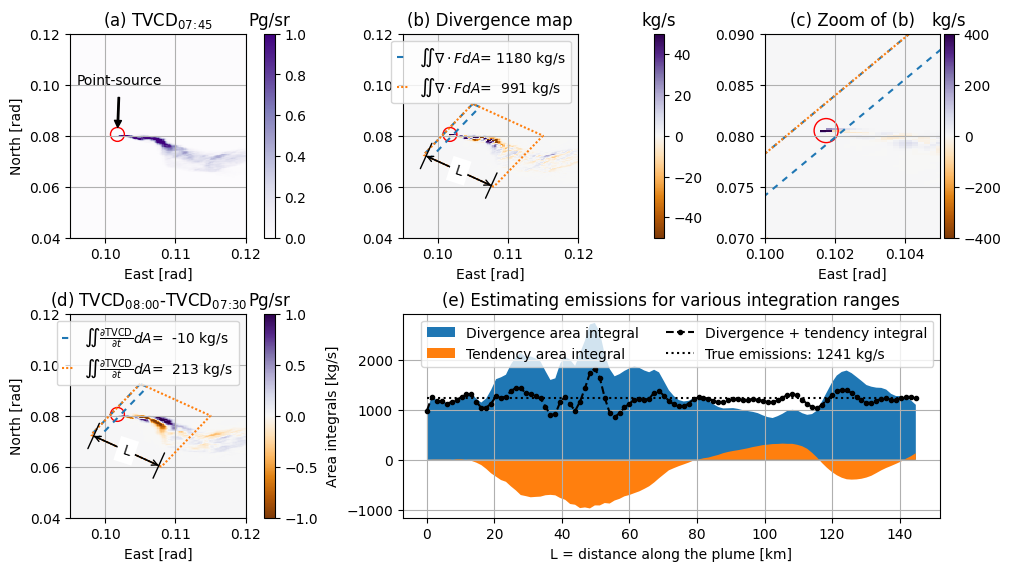

In [5]:
import matplotlib.gridspec as gridspec


fig = plt.figure(figsize=(10*1,4*1.4), layout="constrained")

ax_dict = fig.subplot_mosaic(
    """
    ABC
    DEE
    """)

ax0 = ax_dict['A']
ax1 = ax_dict['B']
ax2 = ax_dict['C']
ax3 = ax_dict['D']
axbottom = ax_dict['E']

div0, div0dxdy = div_method(F.Fx, F.Fy, X, Y)

# Figure 1: TVCD
d0 = ax0.pcolor(X, Y, TVCD[1]/1e12, cmap='Purples', vmax=1, rasterized=True )
ax0.grid()
ax0.set_title('(a) TVCD$_\mathrm{07\!{:}\!45}$')
cb = fig.colorbar(d0, ax=ax0, pad=0.02)
cb.ax.set_title('Pg/sr')
ax0.set_xlabel('East [rad]')
ax0.set_ylabel('North [rad]')
ax0.set_xlim([0.095, 0.12])
ax0.set_ylim([0.04, 0.12])
ax0.scatter( 0.10175, 0.0805, s=100, facecolors='none', edgecolors='r')
ax0.annotate('Point-source', xy=(0.10175, 0.0805), xytext=(0.102, 0.1),
             arrowprops=dict(facecolor='black', shrink=0.15, width=1, headwidth=5, headlength=5), horizontalalignment='center',
             )

# Figure 2
d1 = ax3.pcolor(X, Y, (TVCD[2]-TVCD[0])/1e12, vmin=-1, vmax=1, cmap='PuOr', rasterized=True )
ax3.grid()
ax3.set_title('(d) TVCD$_\mathrm{08\!{:}\!00}$-TVCD$_\mathrm{07\!{:}\!30}$', x=0.45)
cb = fig.colorbar(d1, ax=ax3, pad=0.02)
cb.ax.set_title('Pg/sr')
ax3.set_xlabel('East [rad]')
ax3.set_ylabel('North [rad]')
ax3.set_xlim([0.095, 0.12])
ax3.set_ylim([0.04, 0.12])
ax3.scatter( 0.10175, 0.0805, s=100, facecolors='none', edgecolors='r')

# Figure 3
d1 = ax1.pcolor(X, Y, div0dxdy, cmap='PuOr', vmin=-50, vmax=50, rasterized=True )
ax1.grid()
ax1.set_title('(b) Divergence map')
cb = fig.colorbar(d1, ax=ax1, pad=0.02)
cb.ax.set_title('kg/s')
ax1.set_xlabel('East [rad]')
# ax2.set_ylabel('North [rad]')
ax1.set_xlim([0.095, 0.12])
ax1.set_ylim([0.04, 0.12])
ax1.scatter( 0.10175, 0.0805, s=100, facecolors='none', edgecolors='r')

# Figure 4
d1 = ax2.pcolor(X, Y, div0dxdy, cmap='PuOr', vmin=-400, vmax=400, rasterized=True )
ax2.grid()
ax2.set_title('(c) Zoom of (b)')
cb = fig.colorbar(d1, ax=ax2, pad=0.02)
cb.ax.set_title('kg/s')
ax2.set_xlabel('East [rad]')
# ax2.set_ylabel('North [rad]')
ax2.set_xlim([0.1, 0.105])
ax2.set_ylim([0.07, 0.09])
ax2.scatter( 0.10175, 0.0805, s=300, facecolors='none', edgecolors='r')

pt1 = np.asarray([0.105,0.0925]) 
pt2 = np.asarray([0.098,0.0725])
vecX = np.asarray([0.01, -0.0125])
vecY = np.asarray([0.007, +0.02])

for scalar in [1,0.1][::-1]:
    pts=np.asarray([
        pt1,
        pt2,
        pt2+scalar*vecX,
        pt2+scalar*vecX+vecY,
        pt2+vecY
    ])
    x_line, y_line = return_closed_curve(pts, npts=1000, k=1)
    DIV = divergence(F.Fx.T, F.Fy.T, x, y).T
    # Apply factor 1/2 at edges of the mask (in y direction)
    mask = create_mask(X, Y, x_line, y_line)
    mask_ax1 = half_mask_at_edges(mask, axis=1)
    DIV_int = np.trapz( DIV*mask_ax1 , dx=y[1]-y[0], axis=1)
    # Apply factor 1/2 at edges of the mask (in x direction)
    mask_sum = mask.sum(axis=1)!=0
    mask_ax0 = half_mask_at_edges( mask_sum[:,np.newaxis] ).squeeze()
    DIV_int = np.trapz( DIV_int*mask_ax0 , dx=x[1]-x[0]  )
    time_dif = (TVCD[2].time.values - TVCD[0].time.values).astype('float')/1e9
    CHA_int = np.trapz( (TVCD[2]-TVCD[0])/time_dif*mask_ax1 , dx=y[1]-y[0], axis=1) # Divide by time interval for Backward Euler approx.
    TMP_int = np.trapz( CHA_int*mask_ax0 , dx=(x[1]-x[0])  ) # Is missing a cosine term fix; but this will be SUPER minor.
    DIV_int = DIV_int
    line1, = ax3.plot(x_line, y_line, '--', dashes=(3,3), label=r'$\iint \frac{{\partial \mathrm{{TVCD}} }}{{\partial t}} dA$={:5.0f} kg/s'.format(TMP_int))
    line2, = ax1.plot(x_line, y_line, '--', dashes=(3,3), label=r'$\iint \nabla \cdot F dA$={:5.0f} kg/s'.format(DIV_int))
    line3, = ax2.plot(x_line, y_line, '--', dashes=(3,3))

    
line1.set_dashes((1, 1))  # Adjust the line's dash pattern and offset
line2.set_dashes((1, 1))  # Adjust the line's dash pattern and offset
line3.set_dashes((1, 1))  # Adjust the line's dash pattern and offset

w = pt2+scalar*vecX
ht = pt2
ax1.annotate("", xy=ht, xytext=w, textcoords=ax1.transData, arrowprops=dict(arrowstyle='<->', facecolor='black', ))
ax1.annotate("", xy=ht, xytext=w, textcoords=ax1.transData, arrowprops=dict(arrowstyle='|-|', facecolor='black',))
bbox=dict(fc="white", ec="none")
ax1.text(*(w+ht)/2, "L", ha="center", va="center", bbox=bbox, rotation=-18)

ax3.annotate("", xy=ht, xytext=w, textcoords=ax3.transData, arrowprops=dict(arrowstyle='<->', facecolor='black', ))
ax3.annotate("", xy=ht, xytext=w, textcoords=ax3.transData, arrowprops=dict(arrowstyle='|-|', facecolor='black',))
ax3.text(*(w+ht)/2, "L", ha="center", va="center", bbox=bbox, rotation=-18)

ax1.legend(handlelength=0.8)
ax3.legend(handlelength=0.8)

L1 = axbottom.fill_between((scv-0.08)*6371*np.linalg.norm(vecX), DIV_av, label='Divergence area integral')
L2 = axbottom.fill_between((scv-0.08)*6371*np.linalg.norm(vecX), TMP_av, 0, label='Tendency area integral')
L3 = axbottom.plot((scv-0.08)*6371*np.linalg.norm(vecX), DIV_av+TMP_av, 'k--.', label='Divergence + tendency integral')
L4 = axbottom.plot((scv-0.08)*6371*np.linalg.norm(vecX), scv*0+1241, 'k:', label='True emissions: 1241 kg/s')
# axbottom.set_xlim([0, 155])
axbottom.set_xlabel('L = distance along the plume [km]')
axbottom.set_ylabel('Area integrals [kg/s]')
axbottom.set_title('(e) Estimating emissions for various integration ranges')
axbottom.grid()
axbottom.legend(ncol=2)
# lns = L1+L2+L3+L4
# labs = [l.get_label() for l in lns]
# axlegend.legend(lns, labs, loc=0)

plt.savefig('plume_integration_areas_smallerlayout.pdf', dpi=300, bbox_inches='tight')


In [6]:
DIV_av.mean(), (DIV_av+TMP_av).mean()

(1464.7719940308466, 1214.8036882071353)